# Lab 6: Random Forest Regression on Malagasy Mammal Traits

### Introduction
 In Lab 5, we used functional trait data on bird species to predict their presence in a given climate type. This week we are using regression tree models on a similar dataset, this one on mammal species.  Our goal is to predict the total number of climate types each mammal species inhabits.

You will compare performance of a single decision tree with a tuned random forest to get a sense of the effectiveness of ensemble methods with optimized hyperparameter values.

There is a fair amount of missing data in this set, which can lead to low reliability of feature splits, increased overfitting, and decreased accuracy of tree models. You will address this issue with a combination of variable omission and imputation.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

### Step 1: Read data and retain a subset of the columns
Similar to last week, we will need to take some steps to get the data in a usable form. We again reformat the diet-related variable names to match this set: `Diet_Vertebrates`,
    `Diet_Fruits`, `Diet_Flowers`, `Diet_Seeds`, `Diet_Plants`, `Diet_Other`. Then drop columns that are not relevant functional traits or climate type variables.   Next, drop any remaining  variables that have greater than 40% of the observations missing. Print the final dataframe shape. 

In [2]:
# Read in data
dat = pd.read_csv("/courses/EDS232/Data/MamTraitData.csv", na_values = "-999", encoding="ISO-8859-1").rename(columns={
    'Diet: invertebrates': 'Diet_Invertebrates',
    'Diet: vertebrates': 'Diet_Vertebrates',
    'Diet: fruits': 'Diet_Fruits',
    'Diet: flower/nectar/pollen/gums': 'Diet_Flowers',
    'Diet: seeds': 'Diet_Seeds',
    'Diet: other plant materials': 'Diet_Plants',
    'Diet: scavenge; garbage; carrion; carcasses': 'Diet_Other'
})

# View columns
print(dat.columns)

dat.head()

Index(['AdultBodyMass', 'CranialCapacity', 'Diet_Invertebrates',
       'Diet_Vertebrates', 'Diet_Fruits', 'Diet_Flowers', 'Diet_Seeds',
       'Diet_Plants', 'Diet_Other', 'HabitatBreadth', 'ActivityCycle',
       'ForagingStratum', 'GestationLength', 'LitterSize',
       'InterbirthInterval', 'HomeRange', 'PopulationDensity', 'SocialGrpSize',
       'Longevity', 'Dry', 'Humid', 'Montane', 'Subarid', 'Subhumid'],
      dtype='object')


,AdultBodyMass,CranialCapacity,Diet_Invertebrates,Diet_Vertebrates,Diet_Fruits,Diet_Flowers,Diet_Seeds,Diet_Plants,Diet_Other,HabitatBreadth,...,InterbirthInterval,HomeRange,PopulationDensity,SocialGrpSize,Longevity,Dry,Humid,Montane,Subarid,Subhumid
0,78.0,NaN,yes,no,yes,yes,no,yes,no,1.0,...,365.0,10.40,18.00,1.0,107.8,0,1,1,0,1
1,1082.0,NaN,no,no,yes,no,no,yes,no,1.0,...,NaN,NaN,NaN,NaN,NaN,0,1,0,0,1
2,946.0,NaN,no,no,yes,no,no,yes,no,2.0,...,NaN,0.02,NaN,NaN,NaN,1,0,0,0,0
3,1180.0,10.0,no,no,yes,no,no,yes,no,2.0,...,365.0,0.01,84.85,2.0,NaN,1,1,1,0,1
4,1212.5,NaN,no,no,yes,no,no,yes,no,1.0,...,NaN,NaN,114.00,NaN,NaN,0,1,0,1,1


In [3]:
# Look at shape
print(f"Initial DataFrame shape: {dat.shape}")

# Look at na values
print(f"NA values:\n {dat.isna().sum()}")

# Drop columns with na values over 40% 
df = dat.drop(['CranialCapacity', 
               'GestationLength', 
               'InterbirthInterval', 
               'HomeRange', 
               'PopulationDensity', 
               'SocialGrpSize', 
               'Longevity'], axis=1).copy()

print(f"Final DataFrame shape: {df.shape}")

Initial DataFrame shape: (214, 24)
NA values:
 AdultBodyMass           3
CranialCapacity       171
Diet_Invertebrates     15
Diet_Vertebrates       15
Diet_Fruits            15
Diet_Flowers           15
Diet_Seeds             15
Diet_Plants            15
Diet_Other             15
HabitatBreadth         26
ActivityCycle          22
ForagingStratum        24
GestationLength       118
LitterSize             83
InterbirthInterval    129
HomeRange             151
PopulationDensity     163
SocialGrpSize         136
Longevity             131
Dry                     0
Humid                   0
Montane                 0
Subarid                 0
Subhumid                0
dtype: int64
Final DataFrame shape: (214, 17)


### Step 2: Imputation with KNN
Now impute the values of the missing data in the remaining numeric columns using k-nearest neighbors with `KNNImputer()`. Use the 5 nearest neighbors. This allows us to implement the knn algorithm to predict the missing values for an observation based on similar complete observations.Perform and print a check to ensure that there are no more NA values. 

In [4]:
df.dtypes

AdultBodyMass         float64
Diet_Invertebrates     object
Diet_Vertebrates       object
Diet_Fruits            object
Diet_Flowers           object
Diet_Seeds             object
Diet_Plants            object
Diet_Other             object
HabitatBreadth        float64
ActivityCycle         float64
ForagingStratum       float64
LitterSize            float64
Dry                     int64
Humid                   int64
Montane                 int64
Subarid                 int64
Subhumid                int64
dtype: object

In [5]:
# Separate numerical and categorical columns
numerical = df.select_dtypes(exclude = ['object']).columns
categorical = df.select_dtypes(include = ['object']).columns

# Impute numerical columns
imputer_num = KNNImputer(n_neighbors = 5)
df[numerical] = imputer_num.fit_transform(df[numerical])

# Impute categorical columns
imputer_cat = SimpleImputer(strategy='most_frequent')
df[categorical] = imputer_cat.fit_transform(df[categorical])

# Check
print(df.isna().sum())

AdultBodyMass         0
Diet_Invertebrates    0
Diet_Vertebrates      0
Diet_Fruits           0
Diet_Flowers          0
Diet_Seeds            0
Diet_Plants           0
Diet_Other            0
HabitatBreadth        0
ActivityCycle         0
ForagingStratum       0
LitterSize            0
Dry                   0
Humid                 0
Montane               0
Subarid               0
Subhumid              0
dtype: int64


In [6]:
# Create new column `nClimates`
df['nClimates'] = df['Dry'] + df['Humid'] + df['Montane'] + df['Subarid'] + df['Subhumid']

# Drop old columns
df.drop(['Dry',
         'Humid', 
         'Montane',
         'Subarid',
         'Subhumid'], axis=1, inplace = True)
# Check
df.columns

Index(['AdultBodyMass', 'Diet_Invertebrates', 'Diet_Vertebrates',
       'Diet_Fruits', 'Diet_Flowers', 'Diet_Seeds', 'Diet_Plants',
       'Diet_Other', 'HabitatBreadth', 'ActivityCycle', 'ForagingStratum',
       'LitterSize', 'nClimates'],
      dtype='object')

In [7]:
# Recode categorical predictors to integers
le = LabelEncoder()

for column in categorical:
    df[column] = le.fit_transform(df[column])
    
# Check    
df.dtypes

AdultBodyMass         float64
Diet_Invertebrates      int64
Diet_Vertebrates        int64
Diet_Fruits             int64
Diet_Flowers            int64
Diet_Seeds              int64
Diet_Plants             int64
Diet_Other              int64
HabitatBreadth        float64
ActivityCycle         float64
ForagingStratum       float64
LitterSize            float64
nClimates             float64
dtype: object

### Step 3: Create target variable and numerical encoding 
Create the target variable (`nClimates`) representing the  number of climates in which a species was present. Then finish preparing the data to be used in our models.

- Create a new column `nClimates` that combines the information of the five climate type variables
- Drop the original `Dry`, `Humid`, `Montane`, `Subarid`, and `Subhumid` columns
- Encode categorical variables
- Split the dataset into training and test sets. Use a random state of 808. 

In [8]:
# Select features and target
X = df[['AdultBodyMass',  
        'Diet_Invertebrates', 
        'Diet_Vertebrates',
        'Diet_Fruits', 
        'Diet_Flowers', 
        'Diet_Seeds', 
        'Diet_Plants', 
        'Diet_Other',
       'HabitatBreadth',
       'ActivityCycle',
       'ForagingStratum',
       'LitterSize']]

y = df['nClimates']

# Split the data into testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 808)

### Step 4: Train a decision tree
Train a single decision tree to predict the number of climate types inhabited by each species.

- Train a `DecisionTreeRegressor`.  Let's apply a constraint on its growth by not allowing the tree to grow further than 5 levels. Use a random state of 808. 
- Make predictions
- Visualize the decision tree using `plot_tree`
- Evaluate and print its performance using mse

In [9]:
# Single DT
regressor = DecisionTreeRegressor(max_depth = 5, random_state = 808)
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

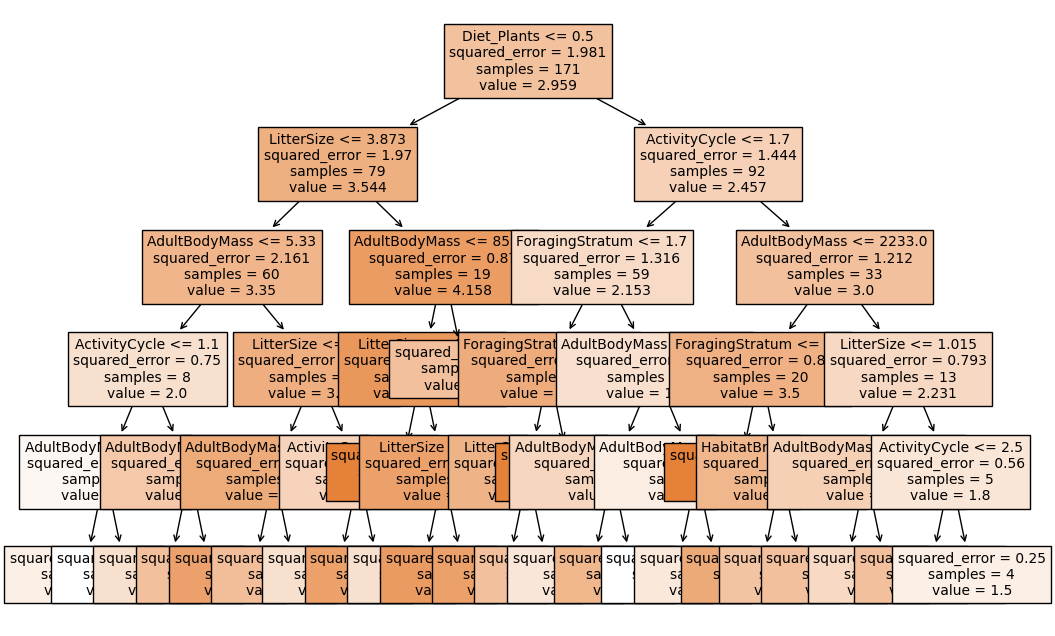

In [10]:
# Plot decision tree
plt.figure(figsize=(12,8))
plot_tree(regressor, filled=True, feature_names=df.columns, fontsize = 10)
plt.show()

In [11]:
# Calculate mean squared error
dt_mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {dt_mse}")

Mean Squared Error: 2.3778884705662513


Based on the way this tree looks, what would you guess the most important variable to be?

I would guess that the most important variable is `Diet_Plants` as it is the first split. 

### Step 5: Random forest with hyperparameter tuning
Now we'll use a more sophisticated ensemble approach where we optimize the values of key hyperparameters that govern tree growth.

- Define a parameter grid that includes the follow parameters and values:
  -  (sqrt(p), 6, and no set #) of the number of features to try at each split
  -  (50, 100, 200) total trees (learners)
  -  a maximum tree depth of (3,4,5,6,7)
  -  (2,5,10) minimum samples per split
  -  (1,2,4) minimum samples per leaf
  
- Use `GridSearchCV` with 5-fold cross-validation and mse (`neg_mean_squared_error`) to find the best combination of parameter values
- Train the best estimator.

In [12]:
# Define parameter grid
param_grid = {
    "n_estimators": [50, 100, 200], # trees
    "max_depth": [3, 4, 5, 6, 7], # levels of trees
    "max_features": ["sqrt", 6, None], # m_try number of features tried at each partition
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# Initiate Random Forest
rf = RandomForestRegressor(random_state = 808)

# Find best parameters
gs = GridSearchCV(rf, param_grid = param_grid, n_jobs = -1, return_train_score = True, scoring="neg_mean_squared_error") # cv= 5 is default
gs.fit(X_train, y_train)
print(f"Best params: {gs.best_params_}")

Best params: {'max_depth': 7, 'max_features': 6, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}


In [13]:
# Use best parameters
best_rf = RandomForestRegressor(**gs.best_params_, random_state = 808)
best_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=7, max_features=6, min_samples_split=10,
                      n_estimators=50, random_state=808)

### Step 6: Make predictions and evaluate random forest model
Use the optimized random forest model (`best_rf`) to predict the number of climates a species inhabits and analyze its performance.

- Use `best_rf` and `predict()` method on `X_test` to generate predictions
- Print the best set of parameter values using thte `best_params` method
- Compute and print the mse to evaluate model performance
- Extract feature importance from the trained random forest model
- Visualize feature importance using a bar plot

In [14]:
# Make predictions from optimized random forest 
y_pred_best = best_rf.predict(X_test)

# Evaluate performance
print(f'Best parameters: {gs.best_params_}')
print(f'MSE: {mean_squared_error(y_test, y_pred_best)}')

Best parameters: {'max_depth': 7, 'max_features': 6, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
MSE: 1.6779233952717627


In [15]:
# Extract feature importance
feature_importance = best_rf.feature_importances_

# Create a DataFrame for better visualization
feature_names = X_train.columns  # Assuming X_train is a Pandas DataFrame
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importance
print(importance_df)

               Feature  Importance
0        AdultBodyMass    0.283877
11          LitterSize    0.174571
6          Diet_Plants    0.135424
10     ForagingStratum    0.135177
9        ActivityCycle    0.084947
8       HabitatBreadth    0.042122
1   Diet_Invertebrates    0.029691
5           Diet_Seeds    0.029192
2     Diet_Vertebrates    0.026872
4         Diet_Flowers    0.023278
3          Diet_Fruits    0.020782
7           Diet_Other    0.014066


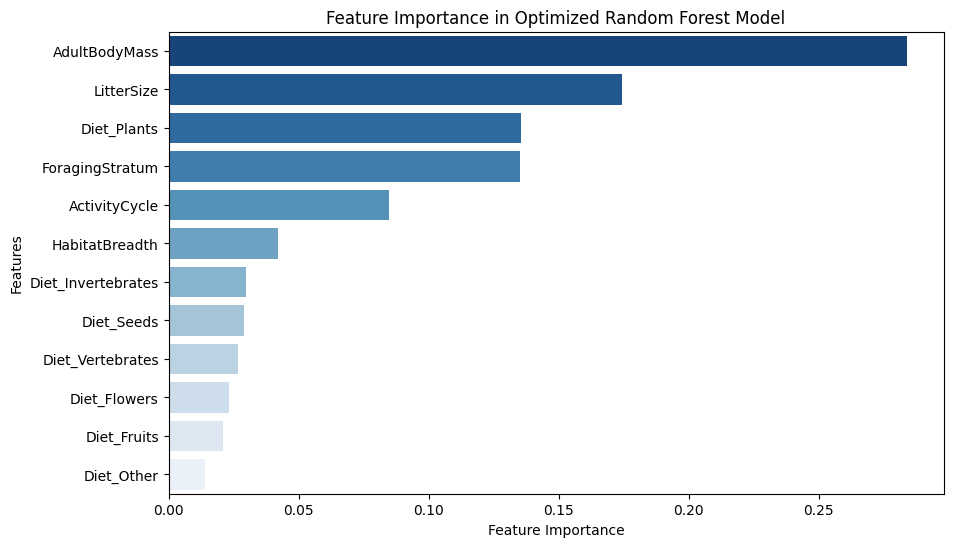

In [16]:
# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=importance_df['Importance'], y=importance_df['Feature'], palette='Blues_r')

# Add labels and title
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Optimized Random Forest Model")

# Show the plot
plt.show()

In [17]:
# Calculate mse
single = mean_squared_error(y_test, y_pred)
ensemble = mean_squared_error(y_test, y_pred_best)

print(f'Single Tree Accuracy: {single:.4f}')
print(f'Ensemble Accuracy: {ensemble:.4f}')

Single Tree Accuracy: 2.3779
Ensemble Accuracy: 1.6779


Which model had better accuracy, the single tree or the ensemble.  Interpret which traits have the most influence on species' climate adaptability.

It appears that the single tree has better accuracy. The traits that have the most influence on species' climate adaptability include `AdultBodyMass`, `LitterSize`, and `Diet_Plants`.